30
30
11 19


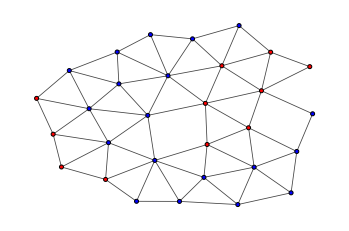

In [133]:
import igraph as ig
import numpy as np
from scipy.spatial import Delaunay
import math
import matplotlib.pyplot as plt
from functools import reduce
import random

np.random.seed(0)



def d_euclidean(v1, v2):
    def adddim(r, l):
        return r+(l[0] - l[1])**2
    r1 = math.sqrt(reduce(adddim, list(zip(v1,v2)), 0))
    return r1

def d_manhatten(v1, v2):
    def adddim(r, l):
        return r+abs(l[0] - l[1])
    r1 = math.sqrt(reduce(adddim, list(zip(v1,v2)), 0))
    return r1

#def d_geodesic(v1, v2, key='len'):
#    return reduce(lambda a,b: ,v1.get_shortest_paths(v2, weights=key), 0)

def distance_GraphObj(v1,v2,distfn=d_euclidean, key='coordinates'):
    if key is None:
        return distfn(v1, v2)
    return distfn(v1[key], v2[key])

dimension=2

def generateRandomGraph(n):
    global dimension
    
    
    g = ig.Graph(n)
    coordinates = np.random.rand(n, dimension)
    g.vs['coordinates'] = coordinates.tolist()
    g.vs['class'] = -1
    g.vs['mark'] = False
    layout = g.layout_auto()
    delaunay = Delaunay(layout.coords)
    for tri in delaunay.simplices:
        g.add_edges([
            (tri[0], tri[1]),
            (tri[1], tri[2]),
            (tri[0], tri[2]),
        ])
    g.simplify()

    g.es['len'] = 0
    g.es['count'] = 1
    for e in g.es:
        g.es[e.index]['len'] = d_euclidean(g.vs[e.source]['coordinates'], g.vs[e.target]['coordinates'])


    edgeindicies = g.es.indices
    sortededges = sorted(edgeindicies, key=lambda x: g.es[x]['len'], reverse=True)
    g.delete_edges(sortededges[:math.floor(g.ecount()*0.05)])

    return g

def showgraph(g):
    print(len(g.vs.select(class_eq=0)), len(g.vs.select(class_eq=1)))
    fig, ax = plt.subplots()
    ig.plot(
        g,
        layout=g.layout(),
        target=ax,
        vertex_size=4,
        edge_width=0.8
    )
    plt.show()

def genRandPartitioning(g, swapping=True, swappingprob=0.3):
    color_dict = {0: "red", 1: "blue"}
    g.vs['class'] = np.random.randint(0, 2, g.vcount())
    g.vs["color"] = [color_dict[vclass] for vclass in g.vs["class"]]
    #showgraph(g)
    if swapping:
        for v in g.vs:
            firstclass = random.choice([0,1])
            secondclass = 1-firstclass
            majoritythreshold = 1
            if (len(g.vs[g.neighbors(v.index, mode="ALL")].select(class_eq=firstclass))>len(g.vs[g.neighbors(v.index, mode="ALL")].select(class_eq=secondclass))+majoritythreshold) and np.random.random() < swappingprob:
                v["class"] = firstclass
            if (len(g.vs[g.neighbors(v.index, mode="ALL")].select(class_eq=secondclass))>len(g.vs[g.neighbors(v.index, mode="ALL")].select(class_eq=firstclass))+majoritythreshold) and np.random.random() < swappingprob:
                v["class"] = secondclass
    g.vs["color"] = [color_dict[vclass] for vclass in g.vs["class"]]
    return g

g = generateRandomGraph(30)
print(g.vcount())
#showgraph(g)
print(g.vcount())
genRandPartitioning(g)
showgraph(g)




In [134]:
import queue



def dnhfactory(vertex, d):
    def rtfn(v):
        return distance_GraphObj(vertex, v) < d
    return rtfn
    
def triangleDeltaFactory(vx, vy, epsilon=0.0):
    def rtfn(v):
        if epsilon == 0.0:
            return distance_GraphObj(v, vx) + distance_GraphObj(v, vy) == distance_GraphObj(vx, vy)
        return distance_GraphObj(v, vx) + distance_GraphObj(v, vy) <= distance_GraphObj(vx, vy) + epsilon
    return rtfn

    
def Delta(x,y, epsilon=0.1):
    return set(g.vs.select(triangleDeltaFactory(x, y, epsilon=epsilon)))

def printset(s):
    idl = []
    for i in s:
        idl.append(id(i))
    print(idl)

def customSetIntersection(A, B):
    return A.intersection(B)
    idl = []
    for i in A:
        idl.append(id(i))

    intersectionset = set()

    for j in B:
        if id(j) in idl:
            intersectionset.add(j)

    return intersectionset
    
def ExtensionalWeaklyConvexHull(g, vertexset, theta, epsilon=0.0):
    g.vs['mark'] = False
    C = set()
    E = set()
    Q = queue.Queue()
    for vertex in vertexset:
        vertex['mark']=True
        Q.put(vertex)
    
    while not Q.empty():
        el = Q.get()
        C.add(el)
        thetanh = set(g.vs.select(dnhfactory(el, theta)))
        for nhel in customSetIntersection(C,thetanh):
            E.add((el, nhel))
            distElNhel = distance_GraphObj(el, nhel)
            
            nhdistel = set(g.vs.select(dnhfactory(el, distElNhel)))
            nhdistnhel = set(g.vs.select(dnhfactory(nhel, distElNhel)))

            intersect = customSetIntersection(nhdistel,nhdistnhel)
            for z in intersect:
                if not z['mark'] and z in Delta(el, nhel, epsilon=epsilon):
                    z['mark']=True
                    Q.put(z)
        return C,E
        

ExtensionalWeaklyConvexHull(g, g.vs.select(class_eq=0), 0.61, epsilon=0.3)

({igraph.Vertex(<igraph.Graph object at 0x7fe4d2cc4f40>, 4, {'coordinates': [0.9636627605010293, 0.3834415188257777], 'class': 0, 'mark': True, 'color': 'red'})},
 {(igraph.Vertex(<igraph.Graph object at 0x7fe4d2cc4f40>, 4, {'coordinates': [0.9636627605010293, 0.3834415188257777], 'class': 0, 'mark': True, 'color': 'red'}),
   igraph.Vertex(<igraph.Graph object at 0x7fe4d2cc4f40>, 4, {'coordinates': [0.9636627605010293, 0.3834415188257777], 'class': 0, 'mark': True, 'color': 'red'}))})

30 0
0 0


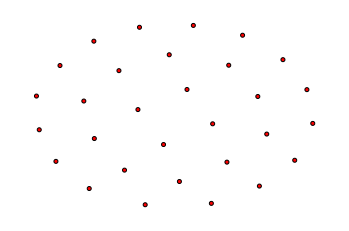

7 23


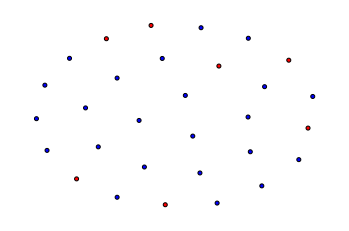

In [135]:
def generateRandomPointCloud(n):
    global dimension
    
    
    g = ig.Graph(n=n, edges=[])
    coordinates = np.random.rand(n, dimension)
    g.vs['coordinates'] = coordinates.tolist()
    g.vs['class'] = -1
    g.vs['mark'] = False
    layout = g.layout_auto()


    return g

h = generateRandomPointCloud(30)
print(h.vcount(), h.ecount())
showgraph(h)
genRandPartitioning(h)
showgraph(h)


In [ ]:
def convSanity1(A, convexhullA):
    return len(A) / len(convexhullA)

def convSanity2(A, convexhullA):
    raise NotImplementedError


In [107]:
'''
Old Stuff, please ignore
'''


class point:

    def __init__(self, dim, coordinates) -> None:
        self.dim=dim
        self.coordinates = coordinates
        self.attrclass = None

    def getCoordinates(self):
        return self.coordinates
    
    def getDim(self):
        return self.dim

    def distance_euclidean(self, otherpoint) -> float:
        if self.dim != otherpoint.getDim():
            raise Exception("incompatible Dimensions")
        return d_euclidean(self.coordinates.tolist(), otherpoint.getCoordinates().tolist())

    def getClass(self):
        return self.attrclass
    
    def setClass(self, attrclass):
        self.attrclass = attrclass

dimension = 3
def randompoints(n):
    points = []
    for i in range(n):
        p = point(dimension, np.random.randint(2, size=dimension))
        points.append(p)

    return points

pts = randompoints(10)
print(pts)

[<__main__.point object at 0x7fe4d2a49a50>, <__main__.point object at 0x7fe4d2a54430>, <__main__.point object at 0x7fe4d2a550c0>, <__main__.point object at 0x7fe4d2a54a30>, <__main__.point object at 0x7fe4d2a55c60>, <__main__.point object at 0x7fe4d2b5e5c0>, <__main__.point object at 0x7fe4d2a55d50>, <__main__.point object at 0x7fe4d2a54760>, <__main__.point object at 0x7fe4d2a56b30>, <__main__.point object at 0x7fe4d2a54cd0>]
